In [1]:
#Importiamo le librerie necessarie
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu, ttest_ind, probplot
from random import choice, seed
from tqdm import tqdm
import seaborn as sns
from itertools import combinations
from sklearn.linear_model import LinearRegression #ci serve per poter utilizzare la regressione lineare
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

Importiamo il file "Measurement_summary.csv" su python utilizzando pandas e rendiamolo Dataframe "df". Per evitare di modificare il dataframe originale andiamo a creare una copia e chiamiamola "Measurement_summary". Il parametro "deep=True" serve per evitare che le modifiche effettuare al dataset Measurement_summary vadano a modificare il dataframe originale. Facciamo lo stesso anche per il file "Measurement_item_info.csv".

In [2]:
df = pd.read_csv("archive/AirPollutionSeoul/Measurement_summary.csv")
Measurement_summary = df.copy(deep=True)

df1 = pd.read_csv("archive/AirPollutionSeoul/Original Data/Measurement_item_info.csv")
Measurement_item_info = df1.copy(deep=True)

Notiamo che la colonna "Measurement date" contiene dati di tipo "oggetto". Convertiamo questi ultimi in dati di tipo "data"

In [3]:
# Convertiamo la colonna 'Measurement date' in un oggetto datetime (integrazione)
Measurement_summary['Measurement date'] = pd.to_datetime(Measurement_summary['Measurement date'], format='%Y-%m-%d %H:%M')

# Verifichiamo il risultato
print("\n*** Informazioni sul dataset con modifica della colonna Measurement date ***\n")
print(Measurement_summary.info())


*** Informazioni sul dataset con modifica della colonna Measurement date ***

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 647511 entries, 0 to 647510
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Measurement date  647511 non-null  datetime64[ns]
 1   Station code      647511 non-null  int64         
 2   Address           647511 non-null  object        
 3   Latitude          647511 non-null  float64       
 4   Longitude         647511 non-null  float64       
 5   SO2               647511 non-null  float64       
 6   NO2               647511 non-null  float64       
 7   O3                647511 non-null  float64       
 8   CO                647511 non-null  float64       
 9   PM10              647511 non-null  float64       
 10  PM2.5             647511 non-null  float64       
dtypes: datetime64[ns](1), float64(8), int64(1), object(1)
memory usage: 54.3+ MB
None


Creiamo ora degli array:
1. distretti: array che contiene tutti gli station code contenuti in "Measurement_summary.csv"
2. anni: array che contiene tutti gli anni in cui sono state effettuate le misurazioni contenuti in "Measurement_summary.csv"
3. inquinanti: array che contiene tutti gli inquinanti che sono contenuti in "Measurement_item_info.csv"

In [4]:
#Creo array che contiene tutte le stazioni di misurazione (tutti i distretti)
distretti = Measurement_summary["Station code"].unique()
print('\n*** I distretti presi in esame sono: ***\n', distretti)

#Creo array che contiene tutti gli anni di rilevazione
anni = Measurement_summary["Measurement date"].dt.year.unique()  

#Creo array che contiene tutti gli inquinanti
inquinanti = Measurement_item_info["Item name"].unique()
print('\n*** Gli inquinanti presi in esame sono: ***\n',inquinanti)


*** I distretti presi in esame sono: ***
 [101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118
 119 120 121 122 123 124 125]

*** Gli inquinanti presi in esame sono: ***
 ['SO2' 'NO2' 'CO' 'O3' 'PM10' 'PM2.5']


Andiamo a sostituire i valori negativi con NaN (Not a Number). 

In [5]:
# Individuo solo le colonne numeriche
numeric_cols = Measurement_summary.select_dtypes(include=[np.number]).columns
# Sostituisco i valori negativi con NaN solo nelle colonne numeriche
Measurement_summary[numeric_cols] = Measurement_summary[numeric_cols].mask(Measurement_summary[numeric_cols] < 0, np.nan)
#print(Measurement_summary)

Ora andiamo ad eliminare gli outlier (valori fuori scala rispetto a tutti gli altri)

In [6]:
tutti_gli_indici_fuori_scala = 0

for inquinante in inquinanti:
    # Calcolo la media e la deviazione standard della colonna dell'inquinante
    media = Measurement_summary[inquinante].mean()
    deviazione_std = Measurement_summary[inquinante].std()

    # Imposto un fattore (es. 3 per considerare valori oltre 3 deviazioni standard come outlier)
    fattore = 3
    soglia_superiore = media + fattore * deviazione_std

    # Trovo gli indici delle righe che contengono valori considerati outlier
    indici_fuori_scala = Measurement_summary[Measurement_summary[inquinante] > soglia_superiore].index
    tutti_gli_indici_fuori_scala += len(indici_fuori_scala)
    
    # Sostituisco i valori outlier con NaN
    Measurement_summary.loc[indici_fuori_scala, inquinante] = np.nan

    # Stampo per monitorare i cambiamenti
    print(f"Outlier per {inquinante}: {len(indici_fuori_scala)} sostituiti con NaN")

# Stampo il totale degli indici fuori scala trovati
print(f"Totale valori outlier sostituiti con NaN: {tutti_gli_indici_fuori_scala}")

Outlier per SO2: 485 sostituiti con NaN
Outlier per NO2: 6 sostituiti con NaN
Outlier per CO: 1867 sostituiti con NaN
Outlier per O3: 74 sostituiti con NaN
Outlier per PM10: 1786 sostituiti con NaN
Outlier per PM2.5: 1491 sostituiti con NaN
Totale valori outlier sostituiti con NaN: 5709


Ora normalizziamo tutti i dati in modo tale da rendere più chiara la visualizzazione

In [7]:
# Creazione dello scaler
scaler = MinMaxScaler()
df_norm = Measurement_summary.copy(deep=True)
df_norm[inquinanti] = scaler.fit_transform(Measurement_summary[inquinanti])
#print(df_norm)

Passiamo ora alla random forest

In [8]:
df_norm_originale = df_norm.copy(deep=True)
print(df_norm_originale)

          Measurement date  Station code  \
0      2017-01-01 00:00:00           101   
1      2017-01-01 01:00:00           101   
2      2017-01-01 02:00:00           101   
3      2017-01-01 03:00:00           101   
4      2017-01-01 04:00:00           101   
...                    ...           ...   
647506 2019-12-31 19:00:00           125   
647507 2019-12-31 20:00:00           125   
647508 2019-12-31 21:00:00           125   
647509 2019-12-31 22:00:00           125   
647510 2019-12-31 23:00:00           125   

                                                  Address   Latitude  \
0       19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republ...  37.572016   
1       19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republ...  37.572016   
2       19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republ...  37.572016   
3       19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republ...  37.572016   
4       19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republ...  37.572016   
...                                    

Troviamo il numero di estimatori

In [33]:
# Copio il dataframe originale
df_norm = df_norm_originale.copy(deep=True)

# Codifico la data come caratteristiche numeriche
df_norm['Day_of_year'] = df_norm['Measurement date'].dt.dayofyear
df_norm['Year'] = df_norm['Measurement date'].dt.year
df_norm['Month'] = df_norm['Measurement date'].dt.month

# Categorizzo "Station code"
df_norm['Station code'] = df_norm['Station code'].astype('category').cat.codes

# Preparo i dati per la ricerca di `n_estimators`
inquinante = 'PM2.5'  
altri_inquinanti = [altro for altro in inquinanti if altro != inquinante]
features = ['Day_of_year', 'Year', 'Month', 'Station code'] + altri_inquinanti

# Uso un campione ridotto del dataset per la ricerca
data = df_norm[features + [inquinante]].dropna().sample(frac=0.6, random_state=42)  # Campiona il 60% del dataset
X = data[features]
y = data[inquinante]

# Controllo che il dataset campionato non sia vuoto
if data.empty:
    raise ValueError("Il dataset campionato è vuoto. Controlla i dati dopo `dropna()`.")

# Definisco il modello e la griglia di parametri
model = RandomForestRegressor(random_state=42, n_jobs=-1)
param_grid = {
    'n_estimators': [120, 130], 
}

# Configuro la metrica per il GridSearchCV
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)

# Configuro il GridSearchCV con un numero ridotto di job e cv
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring=mse_scorer, cv=5, n_jobs=2, verbose=1, error_score='raise')

# Eseguo la ricerca
grid_search.fit(X, y)

# Stampo il miglior numero di estimatori
print("Miglior numero di estimatori:", grid_search.best_params_['n_estimators'])
print("Miglior MSE:", -grid_search.best_score_)

best_n_estimators = grid_search.best_params_['n_estimators']

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Miglior numero di estimatori: 130
Miglior MSE: 0.0014214704869062163


Random forest con variabili categorizzate

Lavorando su: SO2


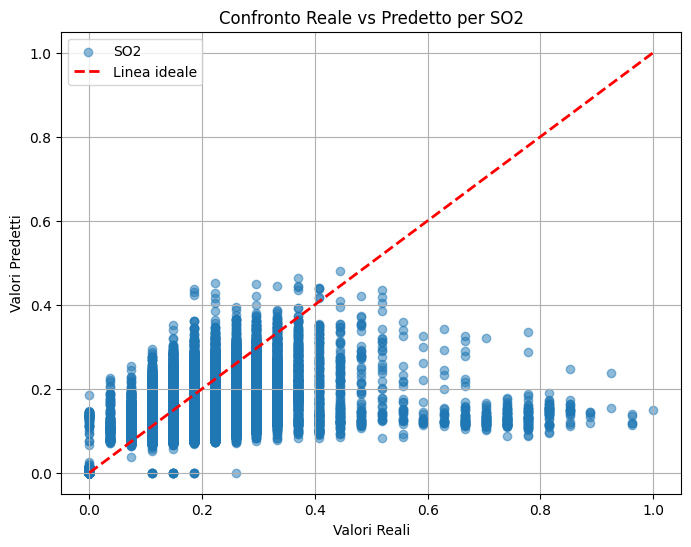

Lavorando su: NO2


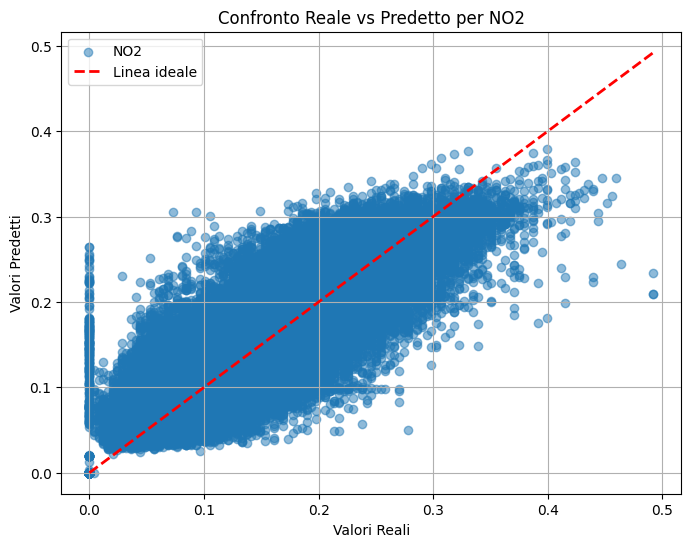

Lavorando su: CO


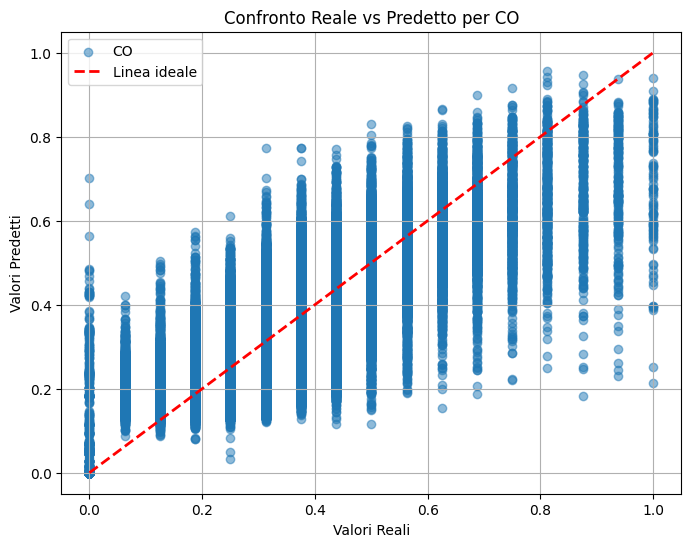

Lavorando su: O3


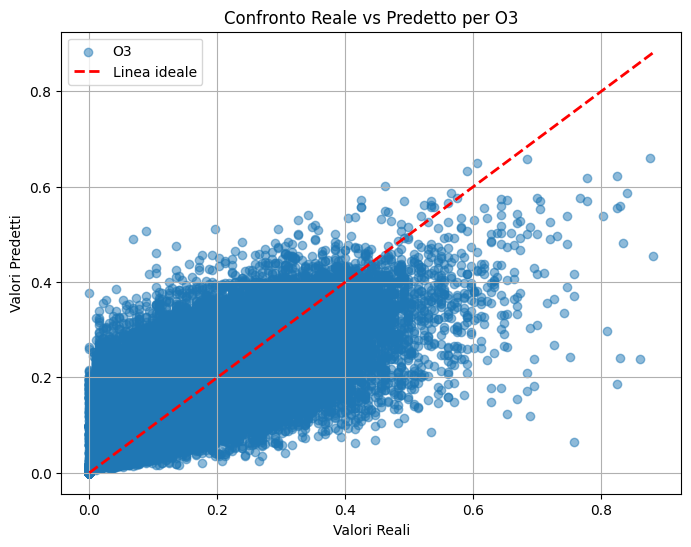

Lavorando su: PM10


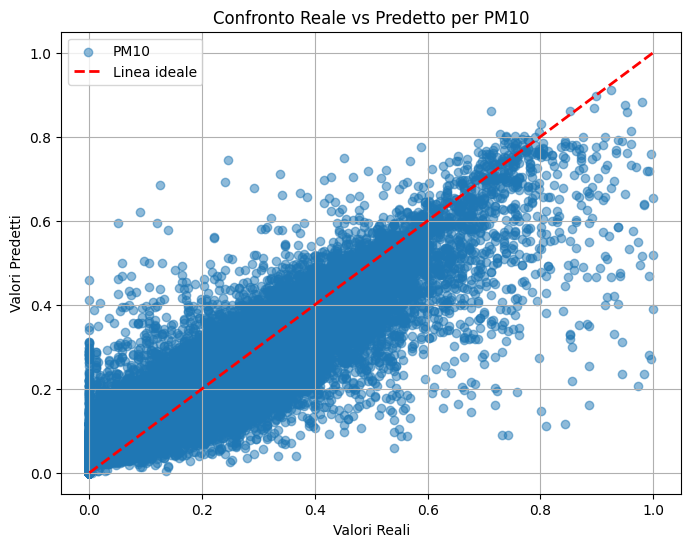

Lavorando su: PM2.5


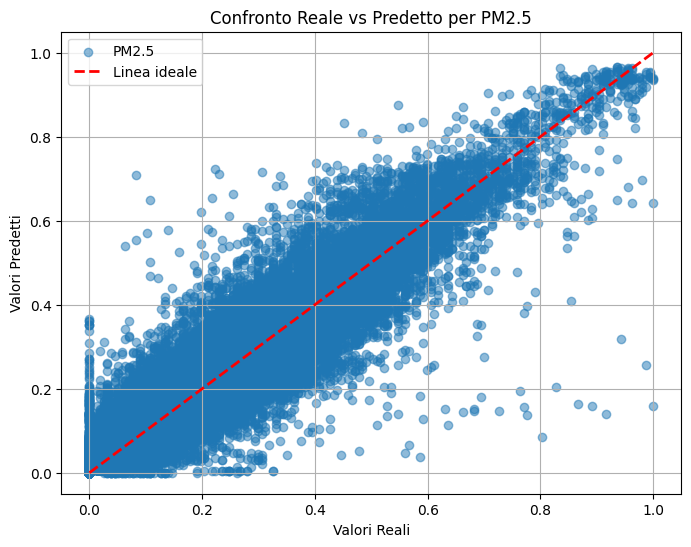



Risultati complessivi:
SO2: MSE=0.0042, R²=-0.0189
NO2: MSE=0.0012, R²=0.7260
CO: MSE=0.0066, R²=0.6624
O3: MSE=0.0036, R²=0.6306
PM10: MSE=0.0022, R²=0.8323
PM2.5: MSE=0.0021, R²=0.8625


Overall results:
SO2: MSE=0.0042, R^2=-0.0189
Error by category:
  - Good: MSE=0.0038
  - Normal: MSE=0.4576
  - Bad: MSE=nan
  - Very Bad: MSE=nan
NO2: MSE=0.0012, R^2=0.7260
Error by category:
  - Good: MSE=0.0009
  - Normal: MSE=0.0015
  - Bad: MSE=0.0022
  - Very Bad: MSE=nan
CO: MSE=0.0066, R^2=0.6624
Error by category:
  - Good: MSE=0.0066
  - Normal: MSE=nan
  - Bad: MSE=nan
  - Very Bad: MSE=nan
O3: MSE=0.0036, R^2=0.6306
Error by category:
  - Good: MSE=0.0027
  - Normal: MSE=0.0048
  - Bad: MSE=0.0492
  - Very Bad: MSE=0.1729
PM10: MSE=0.0022, R^2=0.8323
Error by category:
  - Good: MSE=0.0012
  - Normal: MSE=0.0016
  - Bad: MSE=0.0067
  - Very Bad: MSE=0.0398
PM2.5: MSE=0.0021, R^2=0.8625
Error by category:
  - Good: MSE=0.0010
  - Normal: MSE=0.0016
  - Bad: MSE=0.0043
  - Very Bad: MSE

In [9]:
# Copia del dataframe originale
df_norm = df_norm_originale.copy(deep=True)

# Codifico la data come caratteristiche numeriche
df_norm['Day_of_year'] = df_norm['Measurement date'].dt.dayofyear
df_norm['Year'] = df_norm['Measurement date'].dt.year
df_norm['Month'] = df_norm['Measurement date'].dt.month

# Converto Station code, Day_of_year, Year, Month in categorie
df_norm['Station code'] = df_norm['Station code'].astype('category').cat.codes
df_norm['Day_of_year'] = df_norm['Day_of_year'].astype('category').cat.codes
df_norm['Year'] = df_norm['Year'].astype('category').cat.codes
df_norm['Month'] = df_norm['Month'].astype('category').cat.codes

# Risultati da salvare
result_dict = {}

# Funzione di classificazione aggiornata per utilizzare le soglie normalizzate
def classify_concentration_new(value, thresholds):
    if value <= thresholds['Good(Blue)']:
        return 'Good'
    elif value <= thresholds['Normal(Green)']:
        return 'Normal'
    elif value <= thresholds['Bad(Yellow)']:
        return 'Bad'
    else:
        return 'Very Bad'

for inquinante in inquinanti:
    print(f"Lavorando su: {inquinante}")
    
    # Estraggo le soglie per l'inquinante corrente
    thresholds = Measurement_item_info[Measurement_item_info['Item name'] == inquinante].iloc[0].to_dict()
    #print(thresholds)
    
    # Recupero i valori minimi e massimi per l'inquinante corrente
    min_value = Measurement_summary[inquinante].min()
    max_value = Measurement_summary[inquinante].max()
    
    # Normalizzo le soglie in base a questi minimi e massimi
    normalized_thresholds_dict = {}
    for key in ['Good(Blue)', 'Normal(Green)', 'Bad(Yellow)', 'Very bad(Red)']:
        # Prendiamo il valore della soglia, normalizziamolo utilizzando min-max
        normalized_value = (thresholds[key] - min_value)/ (max_value - min_value)
        normalized_thresholds_dict[key] = normalized_value
    
    # Creo una lista di altri inquinanti, escludendo quello corrente
    altri_inquinanti = [altro for altro in inquinanti if altro != inquinante]
    
    # Preparo i dati
    columns = ['Day_of_year', 'Year', 'Month', 'Station code'] + altri_inquinanti + [inquinante]
    data = df_norm[columns].dropna()  # Rimuovi righe con valori mancanti
    X = data[['Day_of_year', 'Year', 'Month', 'Station code'] + altri_inquinanti]
    y = data[inquinante]

    # Suddivido in train e test (80% train, 20% test)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle= False)

    # Modello di Random Forest
    model = RandomForestRegressor(n_estimators=130, random_state=42, n_jobs=-1)

    # Addestramento del modello
    model.fit(X_train, y_train)

    # Predizione sul set di test
    y_pred = model.predict(X_test)

    # Calcolo delle metriche
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # Salvo i risultati
    result_dict[inquinante] = {
        'mse': mse,
        'r2': r2
    }
    
    # Classifico i valori reali e predetti nelle categorie
    y_test_categories = y_test.apply(classify_concentration_new, thresholds=normalized_thresholds_dict)
    y_pred_categories = pd.Series([classify_concentration_new(val, normalized_thresholds_dict) for val in y_pred], index=y_test.index)

    # Calcolo l'errore per ciascuna categoria
    errors_by_category = {}
    for category in ['Good', 'Normal', 'Bad', 'Very Bad']:
        # Filtro dei dati per categoria
        category_indices = y_test_categories == category
        category_y_test = y_test[category_indices]
        category_y_pred = y_pred[category_indices]
        
        if len(category_y_test) > 0:
            mse_category = mean_squared_error(category_y_test, category_y_pred)
            errors_by_category[category] = mse_category
        else:
            errors_by_category[category] = np.nan  # Se non ci sono dati per quella categoria, assegna NaN

    result_dict[inquinante] = {'mse': mse, 'r2': r2, 'category_errors': errors_by_category}
    
    # Confronto valori reali vs predetti
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.5, label=f'{inquinante}')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Linea ideale')
    plt.xlabel("Valori Reali")
    plt.ylabel("Valori Predetti")
    plt.title(f"Confronto Reale vs Predetto per {inquinante}")
    plt.legend()
    plt.grid()
    plt.show()

# Risultati complessivi
print("\n\nRisultati complessivi:")
for inquinante, metrics in result_dict.items():
    print(f"{inquinante}: MSE={metrics['mse']:.4f}, R²={metrics['r2']:.4f}")

# Risultati finali
print("\n\nOverall results:")
for inquinante, metrics in result_dict.items():
    print(f"{inquinante}: MSE={metrics['mse']:.4f}, R^2={metrics['r2']:.4f}")
    print("Error by category:")
    for category, error in metrics['category_errors'].items():
        print(f"  - {category}: MSE={error:.4f}")

Random forest con subplot e variabili categorizzate

In [ ]:
# Imposto il numero di colonne per i subplot
num_cols = 3
num_rows = (len(inquinanti) + num_cols - 1) // num_cols  # Calcolo il numero di righe necessarie

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10))
axes = axes.flatten() 

for i, inquinante in enumerate(inquinanti):
    # Estraggo le soglie per l'inquinante corrente
    thresholds = Measurement_item_info[Measurement_item_info['Item name'] == inquinante].iloc[0].to_dict()
    
    # Recupero i valori minimi e massimi per l'inquinante corrente
    min_value = Measurement_summary[inquinante].min()
    max_value = Measurement_summary[inquinante].max()
    
    # Normalizzo le soglie
    normalized_thresholds_dict = {key: (thresholds[key] - min_value) / (max_value - min_value) for key in ['Good(Blue)', 'Normal(Green)', 'Bad(Yellow)', 'Very bad(Red)']}
    
    # Preparo i dati
    columns = ['Day_of_year', 'Year', 'Month', 'Station code'] + [altro for altro in inquinanti if altro != inquinante] + [inquinante]
    data = df_norm[columns].dropna()
    X = data[['Day_of_year', 'Year', 'Month', 'Station code'] + [altro for altro in inquinanti if altro != inquinante]]
    y = data[inquinante]
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Modello di Random Forest
    model = RandomForestRegressor(n_estimators=130, random_state=42, n_jobs=-1)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Scatter plot per ogni inquinante
    axes[i].scatter(y_test, y_pred, alpha=0.5)
    axes[i].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    axes[i].set_title(f'{inquinante} - Real vs Predicted')
    axes[i].set_xlabel('Real Values')
    axes[i].set_ylabel('Predicted Values')
    axes[i].grid(True)

# Nascondo gli assi inutilizzati se ci sono meno subplot degli assi
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# Stampo i risultati complessivi
print("\n\nOverall results:")
for inquinante, metrics in result_dict.items():
    print(f"{inquinante}: MSE={metrics['mse']:.4f}, R²={metrics['r2']:.4f}")
    print("Error by category:")
    for category, error in metrics['category_errors'].items():
        print(f"  - {category}: MSE={error:.4f}")

Random forest con trasformazioni cicliche

In [ ]:
# Copia del dataframe originale
df_norm = df_norm_originale.copy(deep=True)

# Codifico la data come caratteristiche numeriche
df_norm['Day_of_year'] = df_norm['Measurement date'].dt.dayofyear
df_norm['Year'] = df_norm['Measurement date'].dt.year
df_norm['Month'] = df_norm['Measurement date'].dt.month

# Normalizzo le variabili temporali
scaler = MinMaxScaler()
df_norm[['Day_of_year', 'Month', 'Year']] = scaler.fit_transform(df_norm[['Day_of_year', 'Month', 'Year']])

# Categorizzo "Station code"
df_norm['Station code'] = df_norm['Station code'].astype('category').cat.codes

# Aggiungo trasformazioni cicliche
df_norm['sin_day'] = np.sin(2 * np.pi * df_norm['Day_of_year'] / 365)
df_norm['cos_day'] = np.cos(2 * np.pi * df_norm['Day_of_year'] / 365)
df_norm['sin_month'] = np.sin(2 * np.pi * df_norm['Month'] / 12)
df_norm['cos_month'] = np.cos(2 * np.pi * df_norm['Month'] / 12)

# Risultati da salvare
result_dict = {}

for inquinante in inquinanti:
    print(f"Lavorando su: {inquinante}")
    
    # Creo una lista di altri inquinanti, escludendo quello corrente
    altri_inquinanti = [altro for altro in inquinanti if altro != inquinante]
    
    # Preparo i dati includendo le caratteristiche temporali e altri inquinanti
    columns = ['sin_day', 'cos_day', 'sin_month', 'cos_month', 'Station code'] + altri_inquinanti + [inquinante]
    data = df_norm[columns].dropna()  # Rimuove righe con valori mancanti

    X = data[['sin_day', 'cos_day', 'sin_month', 'cos_month', 'Station code'] + altri_inquinanti]
    y = data[inquinante]

    # Suddivido in train e test (80% train, 20% test)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle= False)

    # Modello di Random Forest
    model = RandomForestRegressor(n_estimators=130, random_state=42, n_jobs=-1)

    # Addestramento del modello
    model.fit(X_train, y_train)

    # Predizione sul set di test
    y_pred = model.predict(X_test)

    # Calcolo delle metriche
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # Salvo i risultati
    result_dict[inquinante] = {
        'mse': mse,
        'r2': r2
    }
    
    # Confronto valori reali vs predetti
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.5, label=f'{inquinante}')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Linea ideale')
    plt.xlabel("Valori Reali")
    plt.ylabel("Valori Predetti")
    plt.title(f"Confronto Reale vs Predetto per {inquinante}")
    plt.legend()
    plt.grid()
    plt.show()

# Risultati complessivi
print("\n\nRisultati complessivi:")
for inquinante, metrics in result_dict.items():
    print(f"{inquinante}: MSE={metrics['mse']:.4f}, R²={metrics['r2']:.4f}")

# Visualizzazione dei risultati
plt.figure(figsize=(10, 6))
for inquinante, metrics in result_dict.items():
    plt.bar(inquinante, metrics['r2'], label=f'{inquinante} R²')

plt.xlabel('Inquinanti')
plt.ylabel('R² Score')
plt.title('Performance del Modello per Ogni Inquinante')
plt.legend()
plt.grid(True)
plt.show()

FORECASTING

Troviamo estimatori per serie temporale

In [ ]:
# Preprocessing
df_norm = df_norm_originale.copy(deep=True)

# Trasformazioni temporali
df_norm['Day_of_year'] = df_norm['Measurement date'].dt.dayofyear
df_norm['Year'] = df_norm['Measurement date'].dt.year
df_norm['Month'] = df_norm['Measurement date'].dt.month

# Categorizzo station code
df_norm['Station code'] = df_norm['Station code'].astype('category').cat.codes

# Lista degli inquinanti
inquinante_target = 'PM2.5'  # Scelgo questo inquinante per trovare il numero di estimatori 
altri_inquinanti = [inquinante for inquinante in inquinanti if inquinante != inquinante_target]

# Feature e target
features = ['Day_of_year', 'Year', 'Month', 'Station code'] + altri_inquinanti
data = df_norm[features + [inquinante_target]].dropna() 
X = data[features]
y = data[inquinante_target]

# TimeSeriesSplit per rispettare l'ordine temporale
tscv = TimeSeriesSplit(n_splits=5)

# Modello e griglia di ricerca
model = RandomForestRegressor(random_state=42, n_jobs=3)
param_grid = {'n_estimators': [120, 130]}  # Griglia dei parametri
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)

# GridSearch con TimeSeriesSplit
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring=mse_scorer,
    cv=tscv,
    n_jobs=-1,
    verbose=1
)

# Addestramento della griglia
grid_search.fit(X, y)

# Risultati
print("Miglior numero di estimatori:", grid_search.best_params_['n_estimators'])
print("Miglior MSE:", -grid_search.best_score_)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


Modifichiamo random forest tenendo conto che i dati a disposizione rappresentano una serie temporale

Lavorando su: SO2


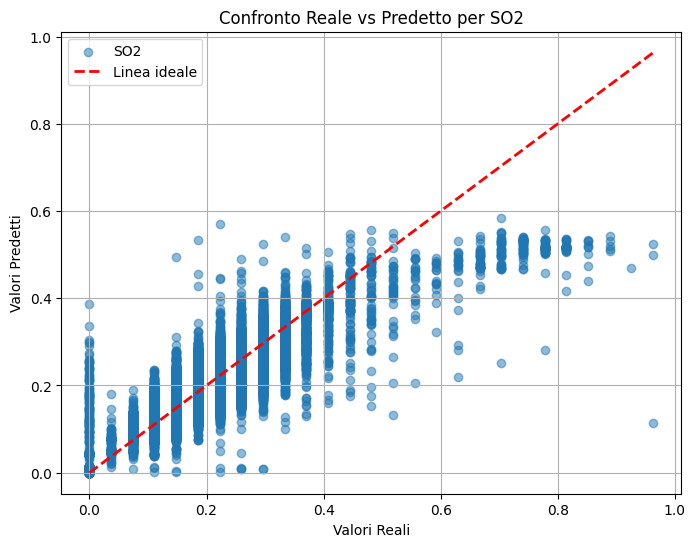

Lavorando su: NO2


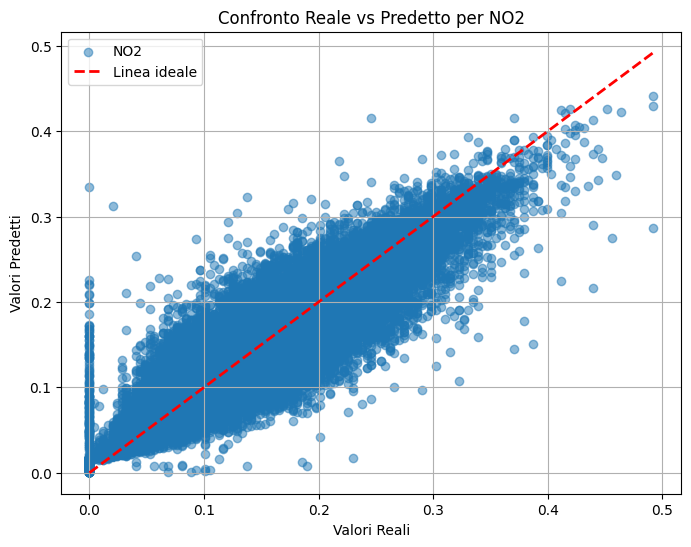

Lavorando su: CO


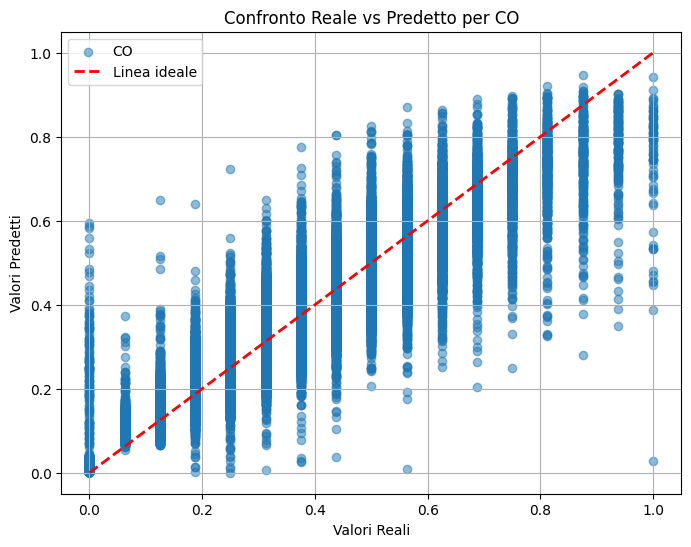

Lavorando su: O3


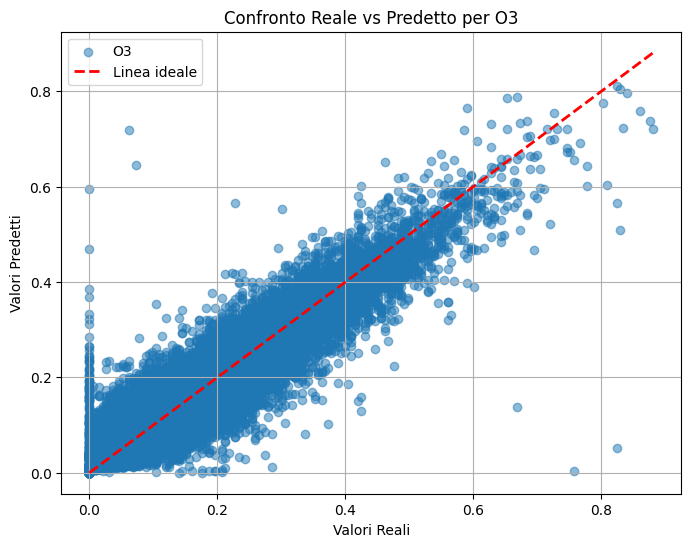

Lavorando su: PM10


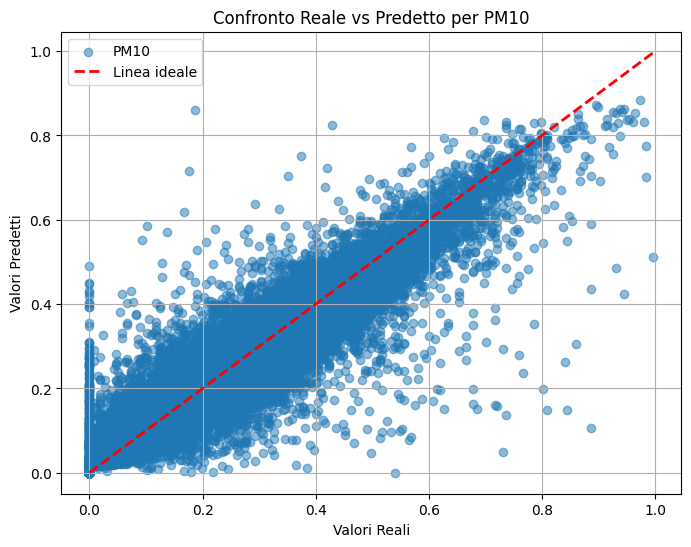

Lavorando su: PM2.5


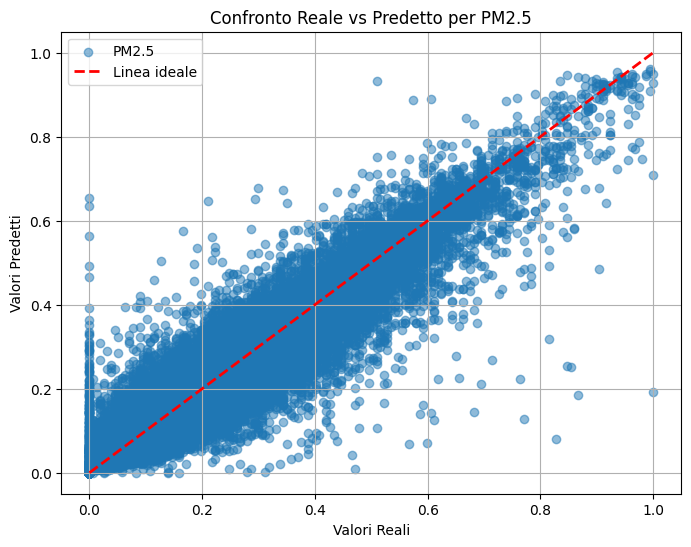



Risultati complessivi:
SO2: MSE=0.0009, R²=0.7766
NO2: MSE=0.0005, R²=0.8817
CO: MSE=0.0028, R²=0.8494
O3: MSE=0.0008, R²=0.9183
PM10: MSE=0.0013, R²=0.8968
PM2.5: MSE=0.0015, R²=0.8970


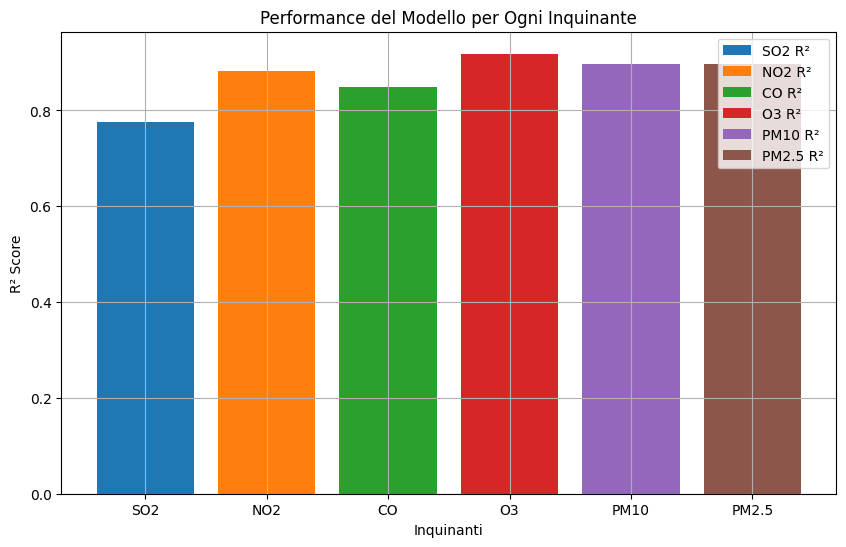

In [13]:
# Copia il dataframe originale
df_norm = df_norm_originale.copy(deep=True)

# Codifico la data come caratteristiche numeriche
df_norm['Day_of_year'] = df_norm['Measurement date'].dt.dayofyear
df_norm['Year'] = df_norm['Measurement date'].dt.year
df_norm['Month'] = df_norm['Measurement date'].dt.month

# Normalizzo le variabili temporali
scaler = MinMaxScaler()
df_norm[['Day_of_year', 'Month', 'Year']] = scaler.fit_transform(df_norm[['Day_of_year', 'Month', 'Year']])

# Categorizzo "Station code"
df_norm['Station code'] = df_norm['Station code'].astype('category').cat.codes

# Aggiungo delle lag features
lag_days = 10
for inquinante in inquinanti:
    for lag in range(1, lag_days + 1):
        df_norm[f'{inquinante}_lag{lag}'] = df_norm[inquinante].shift(lag)

# Rimuovo le righe iniziali con valori NaN causati dalle lag
df_norm = df_norm.dropna()

# Risultati da salvare
result_dict = {}

for inquinante in inquinanti:
    print(f"Lavorando su: {inquinante}")
    
    # Creo la lista delle feature (lag features, variabili temporali e Station code)
    lag_features = [f'{inquinante}_lag{lag}' for lag in range(1, lag_days + 1)]
    features = ['Day_of_year', 'Year', 'Month', 'Station code'] + lag_features
    
    # Variabile target
    target = inquinante
    
    # Suddivido in train e test (80% train, 20% test)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle = False)
    
    # Modello di Random Forest
    model = RandomForestRegressor(n_estimators=130, random_state=42, n_jobs=-1)
    
    # Addestramento del modello
    model.fit(X_train, y_train)
    
    # Predizione
    y_pred = model.predict(X_test)
    
    # Calcolo delle metriche
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # Salvo i risultati
    result_dict[inquinante] = {
        'mse': mse,
        'r2': r2
    }
    
    # Confronto valori reali vs predetti
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.5, label=f'{inquinante}')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Linea ideale')
    plt.xlabel("Valori Reali")
    plt.ylabel("Valori Predetti")
    plt.title(f"Confronto Reale vs Predetto per {inquinante}")
    plt.legend()
    plt.grid()
    plt.show()

# Risultati complessivi
print("\n\nRisultati complessivi:")
for inquinante, metrics in result_dict.items():
    print(f"{inquinante}: MSE={metrics['mse']:.4f}, R²={metrics['r2']:.4f}")

# Visualizzazione dei risultati
plt.figure(figsize=(10, 6))
for inquinante, metrics in result_dict.items():
    plt.bar(inquinante, metrics['r2'], label=f'{inquinante} R²')

plt.xlabel('Inquinanti')
plt.ylabel('R² Score')
plt.title('Performance del Modello per Ogni Inquinante')
plt.legend()
plt.grid(True)
plt.show()

subplot


Training Random Forest model for SO2...
SO2 - Mean Squared Error: 0.0007630610714163947
SO2 - R^2 Score: 0.8123624204937794

Training Random Forest model for NO2...
NO2 - Mean Squared Error: 0.0004314268494348907
NO2 - R^2 Score: 0.8991133136762163

Training Random Forest model for CO...
CO - Mean Squared Error: 0.002306889520010829
CO - R^2 Score: 0.8791134728061837

Training Random Forest model for O3...
O3 - Mean Squared Error: 0.0006529191507129607
O3 - R^2 Score: 0.9323049812027745

Training Random Forest model for PM10...
PM10 - Mean Squared Error: 0.0013003334395188279
PM10 - R^2 Score: 0.8979607184023435

Training Random Forest model for PM2.5...
PM2.5 - Mean Squared Error: 0.001347478321981989
PM2.5 - R^2 Score: 0.9081705824898072


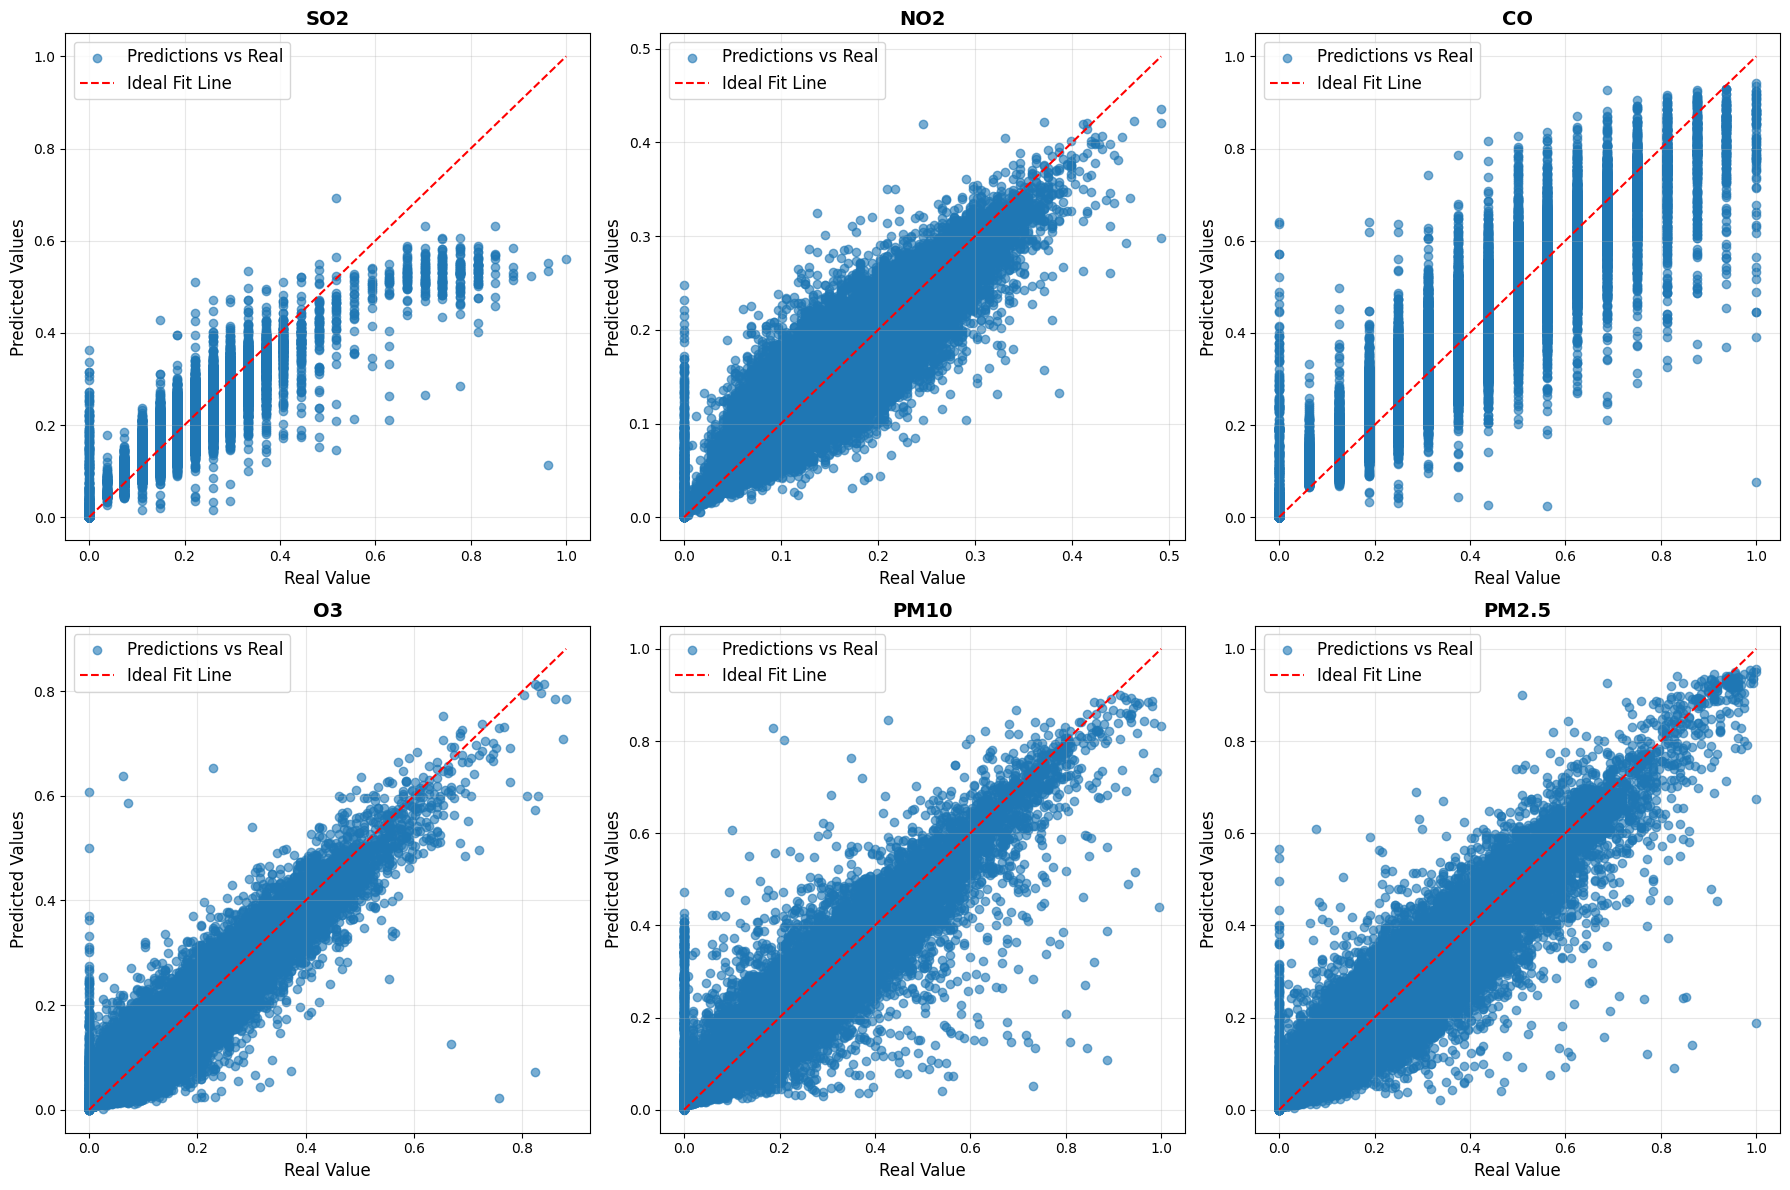



Overall results:
SO2: MSE=0.0008, R^2=0.8124
Error by category:
  - Good: MSE=0.0007
  - Normal: MSE=0.0869
  - Bad: MSE=nan
  - Very Bad: MSE=nan
NO2: MSE=0.0004, R^2=0.8991
Error by category:
  - Good: MSE=0.0003
  - Normal: MSE=0.0006
  - Bad: MSE=0.0011
  - Very Bad: MSE=nan
CO: MSE=0.0023, R^2=0.8791
Error by category:
  - Good: MSE=0.0023
  - Normal: MSE=nan
  - Bad: MSE=nan
  - Very Bad: MSE=nan
O3: MSE=0.0007, R^2=0.9323
Error by category:
  - Good: MSE=0.0005
  - Normal: MSE=0.0009
  - Bad: MSE=0.0055
  - Very Bad: MSE=0.0642
PM10: MSE=0.0013, R^2=0.8980
Error by category:
  - Good: MSE=0.0009
  - Normal: MSE=0.0010
  - Bad: MSE=0.0035
  - Very Bad: MSE=0.0162
PM2.5: MSE=0.0013, R^2=0.9082
Error by category:
  - Good: MSE=0.0007
  - Normal: MSE=0.0010
  - Bad: MSE=0.0027
  - Very Bad: MSE=0.0083


In [16]:
# Copia il dataframe originale
data = df_norm_originale.copy(deep=True)

# Aggiungo caratteristiche temporali
data['year'] = data['Measurement date'].dt.year
data['month'] = data['Measurement date'].dt.month
data['day'] = data['Measurement date'].dt.day
data['hour'] = data['Measurement date'].dt.hour
data['day_of_week'] = data['Measurement date'].dt.dayofweek

# Codifica Station code
data['Station code'] = data['Station code'].astype('category').cat.codes

# Crea lag features per tutti gli inquinanti
lag_range = 3  # Numero di lag
for inquinante in inquinanti:
    for lag in range(1, lag_range + 1):
        data[f'{inquinante}_lag_{lag}'] = data[inquinante].shift(lag)

# Rimuovo righe con valori NaN generati dai lag
data = data.dropna()

# Risultati da salvare
result_dict = {}

# Creo una griglia di subplot con 2 righe e 3 colonne
fig, axes = plt.subplots(2, 3, figsize=(18, 12))  # Dimensioni della griglia
axes = axes.flatten() 

for idx, inquinante in enumerate(inquinanti):
    print(f"\nTraining Random Forest model for {inquinante}...")
    
    # Estraggo le soglie per l'inquinante corrente
    thresholds = Measurement_item_info[Measurement_item_info['Item name'] == inquinante].iloc[0].to_dict()
    min_value = Measurement_summary[inquinante].min()
    max_value = Measurement_summary[inquinante].max()

    # Normalizzo le soglie
    normalized_thresholds_dict = {
        key: (thresholds[key] - min_value) / (max_value - min_value)
        for key in ['Good(Blue)', 'Normal(Green)', 'Bad(Yellow)', 'Very bad(Red)']
    }

    # Caratteristiche
    lag_features = [f'{p}_lag_{l}' for p in inquinanti for l in range(1, lag_range + 1)]
    time_features = ['year', 'month', 'day', 'hour', 'day_of_week']
    station_feature = ['Station code']
    features = lag_features + time_features + station_feature

    X = data[features]
    y = data[inquinante]

    # Suddivido in training/test set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    # Modello di Random Forest
    model = RandomForestRegressor(n_estimators=130, random_state=42, n_jobs=-1)
    model.fit(X_train, y_train)

    # Previsioni
    y_pred = model.predict(X_test)

    # Valutazione
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    result_dict[inquinante] = {'mse': mse, 'r2': r2}

    print(f"{inquinante} - Mean Squared Error: {mse}")
    print(f"{inquinante} - R^2 Score: {r2}")
    
    # Classifico i valori reali e predetti nelle categorie
    def classify_concentration(value, thresholds):
        if value <= thresholds['Good(Blue)']:
            return 'Good'
        elif value <= thresholds['Normal(Green)']:
            return 'Normal'
        elif value <= thresholds['Bad(Yellow)']:
            return 'Bad'
        else:
            return 'Very Bad'

    y_test_categories = y_test.apply(classify_concentration, thresholds=normalized_thresholds_dict)
    y_pred_categories = pd.Series([classify_concentration(val, normalized_thresholds_dict) for val in y_pred], index=y_test.index)

    # Calcolo dell'errore per ciascuna categoria
    errors_by_category = {}
    for category in ['Good', 'Normal', 'Bad', 'Very Bad']:
        category_indices = y_test_categories == category
        category_y_test = y_test[category_indices]
        category_y_pred = y_pred[category_indices]
        if len(category_y_test) > 0:
            mse_category = mean_squared_error(category_y_test, category_y_pred)
            errors_by_category[category] = mse_category
        else:
            errors_by_category[category] = np.nan  # Se non ci sono dati, assegno NaN

    result_dict[inquinante]['category_errors'] = errors_by_category

    # Grafico per Y Predette vs Y Vere
    ax = axes[idx]
    ax.scatter(y_test, y_pred, alpha=0.6, label='Predictions vs Real')
    ax.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Ideal Fit Line')
    ax.set_title(f"{inquinante}", fontsize=14, fontweight='bold')
    ax.set_xlabel("Real Value", fontsize=12)
    ax.set_ylabel("Predicted Values", fontsize=12)
    ax.legend(fontsize=12)
    ax.grid(alpha=0.3)

# Ottimizzo la disposizione dei subplot
plt.tight_layout()
plt.show()

# Risultati complessivi
print("\n\nOverall results:")
for inquinante, metrics in result_dict.items():
    print(f"{inquinante}: MSE={metrics['mse']:.4f}, R^2={metrics['r2']:.4f}")
    print("Error by category:")
    for category, error in metrics['category_errors'].items():
        print(f"  - {category}: MSE={error:.4f}")